# IFT870 - Forage de données - TP1

Membres de l'équipe :
- Joë Larue
- Aurélien Vauthier

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# setup notebook parameters
%matplotlib inline
%load_ext autoreload
%autoreload 2

# disable warnings for computing mahalanobis with NearestCentroid class
import warnings
warnings.filterwarnings('ignore')

# extract data
data = pd.read_csv("TP1_data.csv", index_col=0)
dataNoClass = data.drop("classe", axis=1)

# normalise data
normalisedData = pd.DataFrame( StandardScaler().fit_transform(dataNoClass), data.index, dataNoClass.columns )

# define the classes masks
classMasks = [data["classe"] == classId for classId in range(3)]

print("Affichons un aperçu des premières observations :")
data.head()

Affichons un aperçu des premières observations :


,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


## 1. Représentation des données

Nous allons commencer par étudier les relations entre les variables pour déterminer s'il est nécessaire d’appliquer une transformation des variables basée sur l’analyse des composantes principales (ACP).

Commençons par un pairplot :

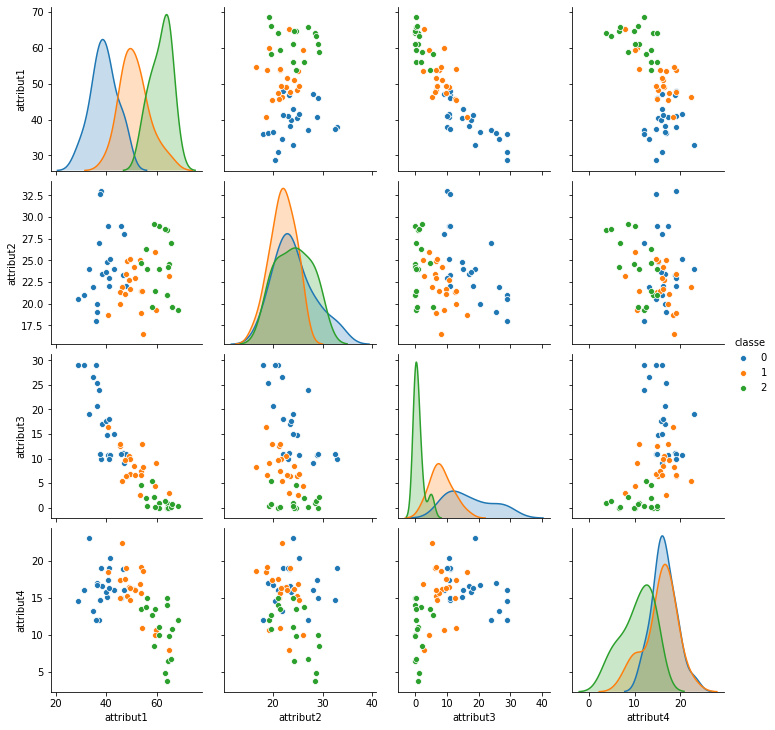

In [3]:
sns.pairplot(data, hue="classe", diag_kind="kde", vars=dataNoClass.columns)

Les classes 0 et 2 sont linéairement séparable avec seulement 2 attributs. 

Comme on peut le voir avec l'histogramme de l'attribut 1, la distribution de la classe 1 fait la liaisons entre les 2 autres classe en se superposant trop pour être linéairement séparable. 

L'attribut 2 et 4 sont assez faibles en information car les centres et les variances de chaques classes sont proches. 

Pour ce qui est de l'attribut 3, la très faible variance de la classe 2 lui permet d'être plus facilement identifiable par rapport à la classe 1

## Les relations de corrélation entre les variables sont-elles similaires pour toutes les 3 classes ?

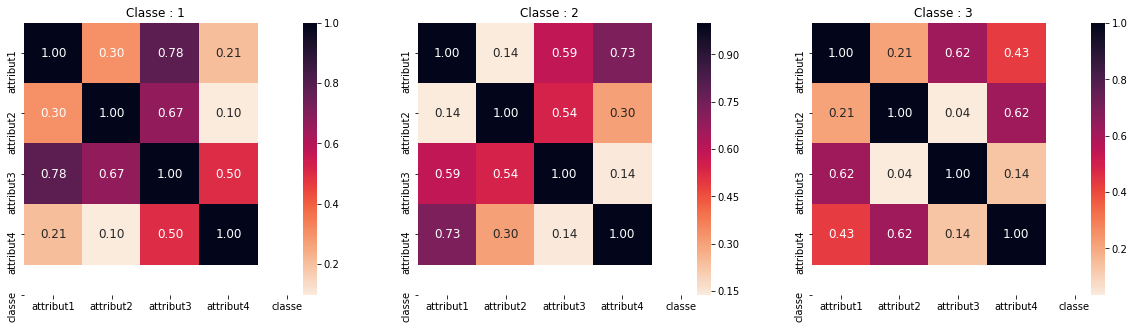

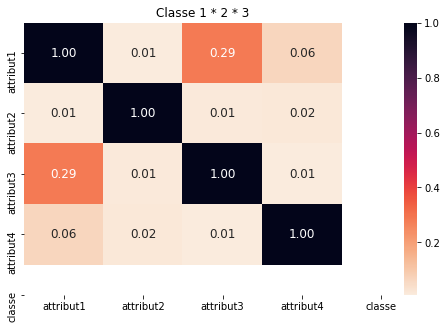

In [34]:
np.corrcoef(dataNoClass.T)
correlationCoef = [np.corrcoef(dataNoClass[classMask].T) for classMask in classMasks]

plt.subplots(figsize=(20,5))
plt.subplot(131,title="Classe : 1")
sns.heatmap(abs(correlationCoef[0]), xticklabels=data.columns, yticklabels=data.columns, annot=True, fmt=".2f", cmap=sns.cm.rocket_r, annot_kws={"fontsize":12} )

plt.subplot(132,title="Classe : 2")
sns.heatmap(abs(correlationCoef[1]), xticklabels=data.columns, yticklabels=data.columns, annot=True, fmt=".2f", cmap=sns.cm.rocket_r, annot_kws={"fontsize":12} )

plt.subplot(133,title="Classe : 3")
sns.heatmap(abs(correlationCoef[2]), xticklabels=data.columns, yticklabels=data.columns, annot=True, fmt=".2f", cmap=sns.cm.rocket_r, annot_kws={"fontsize":12} )

plt.subplots(figsize=(8,5))
plt.subplot(111,title="Classe 1 * 2 * 3")
sns.heatmap(abs(correlationCoef[0])*abs(correlationCoef[1])*abs(correlationCoef[2]), xticklabels=data.columns, yticklabels=data.columns,annot=True, fmt=".2f", cmap=sns.cm.rocket_r, annot_kws={"fontsize":12} )

Les relations de corrélation entre les variables 1&3 (puis 1&4 et 2&3 moindrement) sont similaires pour toutes les 3 classes.

En visualisant la séparation entre les 3 classes après transformation par ACP, déterminez un nombre optimal de composantes principales (CP) à utiliser pour la classification : 2CP ou 3CP.
Vérifiez votre réponse en calculant, pour chaque objet, le centroïde dont il est le plus proche par la distance (Euclidienne) dans les cas 2CP et 3CP, puis en comparant avec les classes réelles des objets.

## En visualisant la séparation entre les 3 classes après transformation par ACP, déterminez un nombre optimal de composantes principales (CP) à utiliser pour la classification : 2CP ou 3CP.
### Vérifiez votre réponse en calculant, pour chaque objet, le centroïde dont il est le plus proche par la distance (Euclidienne) dans les cas 2CP et 3CP, puis en comparant avec les classes réelles des objets.

Résultats des distances moyennes entre une observation et son centroïde pour les données originelles:
   - Classe 0 : 8.8444
   - Classe 1 : 6.7551
   - Classe 2 : 6.1644
Résultats des distances moyennes entre une observation et son centroïde pour l'ACP à 2CP:
   - Classe 0 : 8.1996
   - Classe 1 : 5.9723
   - Classe 2 : 4.2522
Résultats des distances moyennes entre une observation et son centroïde pour l'ACP à 3CP:
   - Classe 0 : 8.7566
   - Classe 1 : 6.6937
   - Classe 2 : 6.1002


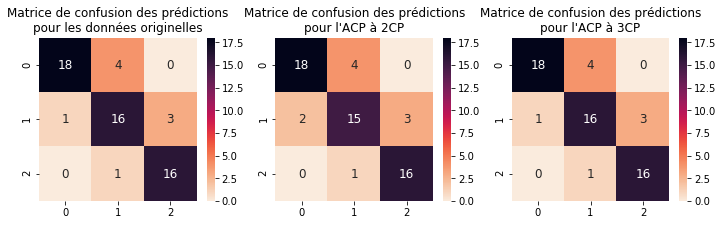

In [5]:
from sklearn.decomposition import PCA
from scipy.linalg import norm

pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)
pcaName = {
    pca2 : "l'ACP à 2CP",
    pca3 : "l'ACP à 3CP",
    None : "les données originelles"
}

fig, axes = plt.subplots(1,3, figsize=(12,3))
    
for pcaIndex, pca in enumerate([None, pca2, pca3]):
    transformedData = dataNoClass.values if pca is None else pca.fit_transform(dataNoClass)
    sumDistances = np.zeros(3)
    predictionConfusionMatrix = np.zeros((3,3), dtype=int)
    
    transformedDataCentroids = [np.mean(transformedData[classMask], axis=0) for classMask in classMasks]
    
    for i, x in enumerate(transformedData):
        dataClass = data["classe"][i]
        sumDistances[dataClass] += norm( transformedDataCentroids[dataClass] - x )
        prediction = np.argmin(norm(transformedDataCentroids - x, axis=1))
        predictionConfusionMatrix[dataClass, prediction] += 1
        
    _, classCounts = np.unique(data["classe"], return_counts=True)
    sumDistances /= classCounts
    
    print(f"Résultats des distances moyennes entre une observation et son centroïde pour {pcaName[pca]}:")
    for i, meanDist in enumerate(sumDistances):
        print(f"   - Classe {i} : {meanDist:.4f}")
    sns.heatmap(predictionConfusionMatrix, annot=True, fmt="d", cmap=sns.cm.rocket_r, ax=axes[pcaIndex],
                annot_kws={"fontsize":12}).set_title(f"Matrice de confusion des prédictions\npour {pcaName[pca]}")

fig.show()

L'idéal est d'avoir une distance moyenne minimale entre les observations et le centroïde d'une classe.

Ici on se rend compte que l'utilisation 2CP est notre meilleur choix.

Cependant, en avançant dans le TP, nous obtenons des résultats plus intéressants avec 3CP, c'est pourquoi celui-ci sera notre choix.

Les matrices de confusion nous affichent par ailleurs 1 erreur de classement de moins avec 3CP qu'avec les autres méthodes.

## 2. Mesure de distance
### D’après les résultats sur l’analyse de corrélation entre les variables de représentation (1.(a)), quelle mesure de distance (Manhattan, Euclidienne, ou Mahalanobis) entre les objets serait la plus adéquate ?

Etant donnée qu'il existe des corrélations significatives entre certains couples d'attributs pour chaque classe, la distance de Mahalanobis semblerait être le choix le plus intéressant.

### Vérifiez votre réponse en calculant pour chacune des mesures de distance, le centroïde le plus proche de chaque objet, puis en comparant avec les classes réelles des objets. Pour la distance de Mahalanobis, on peut utiliser une matrice de covariance par classe ou une matrice de covariance pour toutes les données. Laquelle des deux options est la plus adéquate ?

Résultats des distances moyennes entre une observation et son centroïde pour Manhattan:
   - Classe 0 : 13.2110
   - Classe 1 : 9.5567
   - Classe 2 : 9.2370
Résultats des distances moyennes entre une observation et son centroïde pour Euclidienne:
   - Classe 0 : 8.7566
   - Classe 1 : 6.6937
   - Classe 2 : 6.1002
Résultats des distances moyennes entre une observation et son centroïde pour Mahalanobis (covariance globale):
   - Classe 0 : 1.4481
   - Classe 1 : 1.0915
   - Classe 2 : 1.2268
Résultats des distances moyennes entre une observation et son centroïde pour Mahalanobis (covariance par classe):
   - Classe 0 : 1.5514
   - Classe 1 : 1.5347
   - Classe 2 : 1.5731


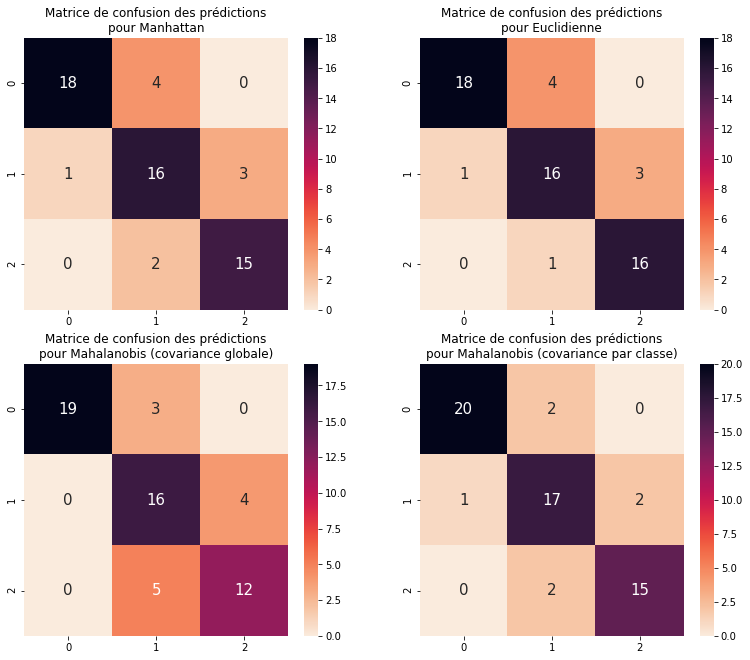

In [13]:
from scipy.spatial.distance import cityblock, euclidean, mahalanobis

fig, axes = plt.subplots(2, 2, figsize=(13,11))

transformedData = pca3.fit_transform(dataNoClass)
transformedDataCentroids = [np.mean(transformedData[classMask], axis=0) for classMask in classMasks]
transformedDataCov = [np.cov(transformedData[classMask], rowvar=False) for classMask in classMasks]
wrongClassified = []

# create the same interface for all distances
distances = [
    lambda x, classId: cityblock(transformedDataCentroids[classId], x),
    lambda x, classId: euclidean(transformedDataCentroids[classId], x),
    lambda x, classId: mahalanobis(transformedDataCentroids[classId], x, np.linalg.inv(np.cov(transformedData, rowvar=False))),
    lambda x, classId: mahalanobis(transformedDataCentroids[classId], x, np.linalg.inv(transformedDataCov[classId]))
]
distName = {
    distances[0] : "Manhattan",
    distances[1] : "Euclidienne",
    distances[2] : "Mahalanobis (covariance globale)",
    distances[3] : "Mahalanobis (covariance par classe)"
}

for distIndex, distance in enumerate(distances):
    sumDistances = np.zeros(3)
    predictionConfusionMatrix = np.zeros((3,3), dtype=int)
    wrongClassified = []
    
    for i, x in enumerate(transformedData):
        dataClass = data["classe"][i]
        sumDistances[dataClass] += distance(x, dataClass)
        prediction = np.argmin([distance(x, target) for target in range(3)])
        predictionConfusionMatrix[dataClass, prediction] += 1
        if prediction != dataClass : wrongClassified.append(x)
        
    _, classCounts = np.unique(data["classe"], return_counts=True)
    sumDistances /= classCounts
    
    print(f"Résultats des distances moyennes entre une observation et son centroïde pour {distName[distance]}:")
    for i, meanDist in enumerate(sumDistances):
        print(f"   - Classe {i} : {meanDist:.4f}")
    sns.heatmap(predictionConfusionMatrix, annot=True, fmt="d", cmap=sns.cm.rocket_r, ax=axes[distIndex//2, distIndex%2], annot_kws={"fontsize":15}).set_title(f"Matrice de confusion des prédictions\npour {distName[distance]}")

fig.show()

Comme nous pouvions nous y attendre, la distance de Malahanobis (covariance par classe) est la plus intéressante au vu des résultats obtenus. 

## 3. Choix du modèle de classification

### En utilisant la meilleure représentation des données retenue au Point 1, et la meilleure mesure de distance retenue au Point 2, tester la méthode des k = 5 plus proches voisins ou la méthode du plus proche centroïde, et déterminez la plus adéquate.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

def getKNN(point, X_train, y_train, k_neighbors=5):
    distances=[]
    for i, x in enumerate(X_train):
        distance = mahalanobis(x, point, np.linalg.inv(transformedDataCov[y_train[i]]))
        distances.append( (distance, y_train[i]) )
    
    distances.sort(key=lambda dist: dist[0])
    
    neighborsClass=[]
    for i in range(k_neighbors):
        neighborsClass.append(distances[i][1])
        
    return neighborsClass

n_splits = 10000
random_state = np.random.RandomState()  # use the same random splits everytime 
spliter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.15, random_state=random_state)

knnPrecision=0
for trainIndexes, testIndexes in spliter.split(transformedData, data["classe"]):
    X_train, X_test = transformedData[trainIndexes], transformedData[testIndexes]
    y_train, y_test = data["classe"][trainIndexes], data["classe"][testIndexes]
    
    errorCount = 0
    for i, x in enumerate(X_test):
        neighborsClass = getKNN(x, X_train, y_train)
        prediction = max(neighborsClass, key=neighborsClass.count)
        if prediction != y_test[i]:
            errorCount += 1
    knnPrecision += 1 - (errorCount / len(X_test))
knnPrecision /= n_splits
print(f"Précision en test de KNN Mahalanobis : {knnPrecision:.3%}")

centroidPrecision = 0
for trainIndexes, testIndexes in spliter.split(transformedData, data["classe"]):
    X_train, X_test = transformedData[trainIndexes], transformedData[testIndexes]
    y_train, y_test = data["classe"][trainIndexes], data["classe"][testIndexes]
    
    # compute X_train's centroids and covariance matrices
    X_train_classMasks = [y_train == classId for classId in range(3)]
    X_train_centroids = [np.mean(X_train[classMask], axis=0) for classMask in X_train_classMasks]
    X_train_cov = [np.cov(X_train[classMask], rowvar=False) for classMask in X_train_classMasks]

    errorCount = 0
    for i, x in enumerate(X_test):
        dist=[mahalanobis(x, X_train_centroids[j], X_train_cov[j]) for j in range(3)]
        prediction = np.argmin(dist)
        if prediction !=y_test[i]:
            errorCount += 1
    centroidPrecision += 1 - (errorCount / len(X_test))
centroidPrecision /= n_splits
print(f"Précision en test de NC Mahalanobis : {centroidPrecision:.3%}")

Précision en test de KNN Mahalanobis : 81.550%
Précision en test de NC Mahalanobis : 82.357%


La méthode la plus adéquate est celle du plus proche centroïde. Cependant, au vu de la faible variance de résultat avec K-NN, nous sommes conscients de l'équivalence de ces méthodes avec nos données.

### On fait l’hypothèse que les objets correspondent à des mélanges de distributions gaussiennes correspondant aux classes. Déterminez si cette hypothèse est vraissemblable en appliquant une classification par modèle de mélange gaussien ("Gaussian Mixture Model”) aux données. Justifiez votre choix parmi les quatre options du modèle pour la covariance des différentes classes (spherical, diag, tied, ou full).

Nous faisons l'hypothèse que le modèle full est probablement le plus intéressant. En effet, les résultats obtenus avec l'application de Malahanobis (partie 2) nous laissent penser que l'utilisation d'une matrice de covariance pour chaque classe permettrait de créer un mélange de modèle gaussien avec la plus grande précision. 

Précision en fonction du type de covariance:
	- spherical :
		- entraînement : 83.045%
		- test : 78.467%
	- diag :
		- entraînement : 75.659%
		- test : 73.667%
	- tied :
		- entraînement : 77.818%
		- test : 72.267%
	- full :
		- entraînement : 76.818%
		- test : 71.667%


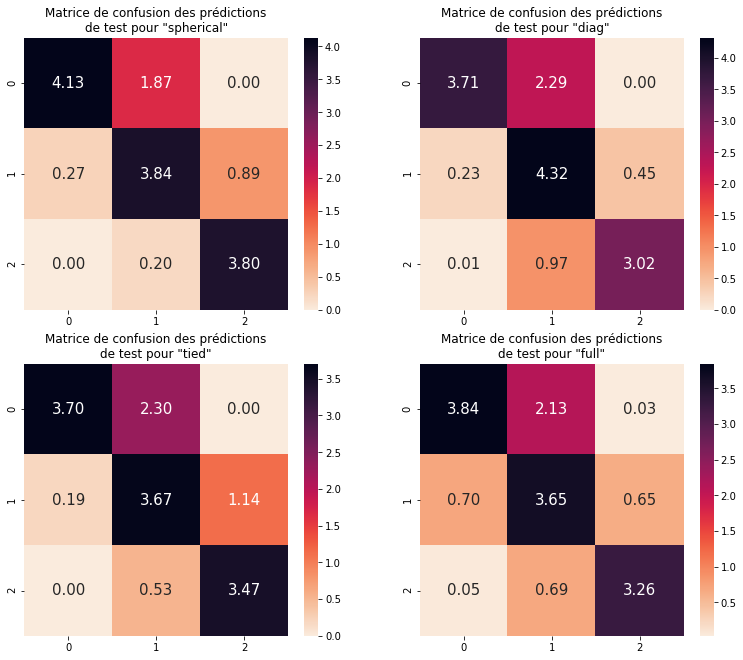

In [25]:
from sklearn.mixture import GaussianMixture

covariance_types = ["spherical", "diag", "tied", "full"]
fig, axes = plt.subplots(2, 2, figsize=(13,11))

n_splits = 100
spliter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25)

trainPrecision = {cov_type: 0 for cov_type in covariance_types}
testPrecision = {cov_type: 0 for cov_type in covariance_types}
confusionMatrix = {cov_type: np.zeros((3,3)) for cov_type in covariance_types}

print("Précision en fonction du type de covariance:")
for trainIndexes, testIndexes in spliter.split(transformedData, data["classe"]):
    X_train, X_test = transformedData[trainIndexes], transformedData[testIndexes]
    y_train, y_test = data["classe"][trainIndexes], data["classe"][testIndexes]
    
    # compute X_train's centroids
    X_train_classMasks = [y_train == classId for classId in range(3)]
    X_train_centroids = [np.mean(X_train[classMask], axis=0) for classMask in X_train_classMasks]
    
    for i, cov_type in enumerate(covariance_types):
        gm = GaussianMixture(n_components=3, covariance_type=cov_type, means_init=X_train_centroids)
        trainPredictions = gm.fit_predict(X_train, y=y_train)
        
        trainPrecision[cov_type] += np.mean( trainPredictions == y_train )
        testPredictions = gm.predict(X_test)
        testPrecision[cov_type] += np.mean( testPredictions == y_test )
        
        # confusionMatrix[cov_type][y_test, testPredictions] += 1/n_splits
        for y, pred in enumerate(testPredictions):
            confusionMatrix[cov_type][y_test[y], pred] += 1/n_splits

best_cov_type = None
best_precision= -np.inf
for i, cov_type in enumerate(covariance_types):    
    sns.heatmap(confusionMatrix[cov_type], annot=True, fmt=".2f", cmap=sns.cm.rocket_r,
                ax=axes[i//2, i%2], annot_kws={"fontsize":15}
                ).set_title(f"Matrice de confusion des prédictions\nde test pour \"{cov_type}\"")

    print(f"\t- {cov_type} :"
          f"\n\t\t- entraînement : {trainPrecision[cov_type]/n_splits:.3%}"
          f"\n\t\t- test : {testPrecision[cov_type]/n_splits:.3%}")

    if testPrecision[cov_type] > best_precision:
        best_precision = testPrecision[cov_type]
        best_cov_type = cov_type
    
fig.show()

D'après les résultats obtenus, il semblerait que le modèle sphérique soit meilleur que les autres. Notre hypothèse ci-dessus est donc fausse. 

## 4. Application

### À l’aide du modèle retenue au Point 3., déterminez la classe de la nouvelle observation suivante : $[52.1, 23.0, 6.1, 16.5]$

In [21]:
x = [[52.1, 23.0, 6.1, 16.5]]
transformed_x = pca3.transform(x)

dist=[mahalanobis(transformed_x, transformedDataCentroids[j], transformedDataCov[j]) for j in range(3)]
prediction = np.argmin(dist)

print(f"La classe de la nouvelle observation est {prediction}")

La classe de la nouvelle observation est 1


In [28]:
gm = GaussianMixture(n_components=3, covariance_type=best_cov_type, means_init=transformedDataCentroids)
gm.fit(transformedData, y=data["classe"])

prediction = gm.predict(transformed_x)[0]

print(f"La classe de la nouvelle observation est {prediction}")

La classe de la nouvelle observation est 1


Nous avons optenu la même prédiction avec la méthode des mélanges de modèles gaussiens (sphérique) et la méthode NC.